In [10]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm, energy_distance
import multiprocessing

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import tensorflow.experimental.numpy as tnp
tnp.experimental_enable_numpy_behavior()

import sys
sys.path.append(".")
from src.dc_smc import dc_smc 
from src.model import Model
from src.utils import resample, weighted_sum, effective_sample_size

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
def plot_hist(ind, samples_plot, samples_init=None, label1=None, label2=None):
    label1 = f"final x{ind}" if label1 is None else label1
    label2 = f"initial x{ind}" if label2 is None else label2
    
    sns.histplot(tf.reshape(samples_plot[:, ind], -1), stat="density", color="r", alpha=0.4, label=label1)
    if samples_init is not None:
        sns.histplot(tf.reshape(samples_init[:, ind], -1), stat="density", alpha=0.4, label=label2)
    ymax = plt.ylim()[1]
    plt.vlines(x_true[0, ind], 0, ymax, color="orange", label="true mu")
    plt.ylim(0, ymax)
    x_plot = np.linspace(2, 4, 500)
    plt.legend()
    plt.show()

    print(
        f"true x_{ind+1}:",
        x_true[0, ind],
        "\nestimate:",
        tf.reduce_mean(samples_plot[:, ind])
    )

# 5-var model

Target:
$$
y_i | x_i \sim \mathcal{N}(x_i, \sigma^2), i = 1, 2, 3 \\
x_i | x_4 \sim \mathcal{N}(x_4, \tau^2), i = 1, 2 \\
x_i | x_5 \sim \mathcal{N}(x_t, \gamma^2), i = 3, 4
$$
Priors:
$$
x_i \sim \mathcal{N}(\mu_0, \sigma_0^2), i = 1, 2, \ldots, 5
$$

In [12]:
tf.random.set_seed(1)

N = 2000 # num params samples
nobs = 1 # 1000 # num observations

sigma, tau, gamma = np.array([1.]), np.array([1.]), np.array([1.])
mu0, sigma0 = np.array([0.]), np.array([1.])

x5 = np.array([-1.])
x4, x3 = tfd.Normal(loc=x5, scale=gamma).sample(2)
x1, x2 = tfd.Normal(loc=x4, scale=tau).sample(2)
x_true = tf.reshape(tf.concat([x1, x2, x3, x4, x5], axis=0), (1, -1))


In [13]:
# simulate data
y1 = tfd.Normal(loc=x_true[:, 0], scale=sigma).sample((nobs, 1))
y2 = tfd.Normal(loc=x_true[:, 1], scale=sigma).sample((nobs, 1))
y3 = tfd.Normal(loc=x_true[:, 2], scale=sigma).sample((nobs, 1))
obs = tf.concat([y1, y2, y3], axis=1)[:, :, 0]
# obs = tf.concat([y1, y2, y3], axis=1)
# obs = tf.transpose(obs, perm=[0, 2, 1])

In [ ]:
def init_target(obs):
    def log_gamma1(x):
        loglik = tfd.Normal(loc=x[:, :1], scale=sigma).log_prob(obs[:, :1].T)
        loglik = tf.reduce_sum(loglik, axis=1, keepdims=True)
        logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, :1])
        return loglik + logprior

    def log_gamma2(x):
        loglik = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[:, 1:2].T)
        loglik = tf.reduce_sum(loglik, axis=1, keepdims=True)
        logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 1:2])
        return loglik + logprior

    def log_gamma3(x):
        loglik = tfd.Normal(loc=x[:, 2:3], scale=sigma).log_prob(obs[:, 2:3].T)
        loglik = tf.reduce_sum(loglik, axis=1, keepdims=True)
        logprior = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 2:3])
        return loglik + logprior

    def log_gamma4(x):
        loglik1 = tfd.Normal(loc=x[:, 0:1], scale=sigma).log_prob(obs[:, :1].T)
        loglik2 = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[:, 1:2].T)
        loglik = tf.reduce_sum(loglik1 + loglik2, axis=1, keepdims=True)
        logp1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 0:1])
        logp2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])
        logp4 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 3:4])
        return loglik + logp1 + logp2 + logp4

    def log_gamma5(x):
        loglik1 = tfd.Normal(loc=x[:, 0:1], scale=sigma).log_prob(obs[:, :1].T)
        loglik2 = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[:, 1:2].T)
        loglik3 = tfd.Normal(loc=x[:, 2:3], scale=sigma).log_prob(obs[:, 2:3].T)
        loglik = tf.reduce_sum(loglik1 + loglik2 + loglik3, axis=1, keepdims=True)
        
        logp1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, :1])
        logp2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])   
        logp3 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 2:3])
        logp4 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 3:4])
        logp5 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 4:5])
        return loglik + logp1 + logp2 + logp3 + logp4 + logp5
    return log_gamma1, log_gamma2, log_gamma3, log_gamma4, log_gamma5

In [ ]:
class Proposal:
    def __init__(self):
        self.dist = tfd.Normal(np.zeros(1), np.ones(1))
    def log_prob(self, mu_new, mu_curr):
        return self.dist.log_prob(mu_new) # nsample x dim
    def sample(self, size, mu_curr):
        return self.dist.sample(size)[:, :, 0]

In [ ]:
proposal = Proposal()
log_gamma1, log_gamma2, log_gamma3, log_gamma4, log_gamma5 = init_target(obs)

model = Model(log_gamma5, proposal, 4)
model.build_child(log_gamma4, proposal, 3)
model.build_child(log_gamma3, proposal, 2)
model.children[0].build_child(log_gamma2, proposal, 1)
model.children[0].build_child(log_gamma1, proposal, 0)

In [ ]:
# initialize samples from N(0, 1)
samples_plot_init = tfd.Normal(loc=np.zeros(1), scale=np.ones(1)).sample((N, x_true.shape[1]))[:, :, 0]
samples_init = tf.Variable(samples_plot_init)

# initialize weights
log_w_init = np.ones_like(samples_init)
log_w_init = tf.Variable(log_w_init)

In [ ]:
samples_res, log_w = dc_smc(samples_init, log_w_init, model)

In [ ]:
samples_plot = tf.Variable(tf.identity(samples_res))
samples_plot = samples_plot[:, -1].assign(resample(log_w, samples_res[:, -1]))
# samples_plot[:, -1] = resample(log_w, samples_res[:, -1])
# samples_plot = tf.convert_to_tensor(samples_plot)

In [ ]:
plot_hist(4, samples_plot, samples_plot_init)

### Compare with results from SMC

In [14]:
def loglik(x):
    loglik1 = tfd.Normal(loc=x[:, 0:1], scale=sigma).log_prob(obs[:, 0:1].T)
    loglik2 = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[:, 1:2].T)
    loglik3 = tfd.Normal(loc=x[:, 2:3], scale=sigma).log_prob(obs[:, 2:3].T)
    loglik = tf.reduce_sum(loglik1 + loglik2 + loglik3, axis=1, keepdims=True)
    return loglik

def logprior(x):
    logp1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 0:1])
    logp2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])   
    logp3 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 2:3])
    logp4 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 3:4])
    logprior5 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 4:5])
    return logp1 + logp2 + logp3 + logp4 + logprior5
    
def log_target(x):
#     return (logprior(x) + loglik(x)).reshape()
    return logprior(x) + loglik(x)

def smc(seed):
    return tfp.experimental.mcmc.sample_sequential_monte_carlo(
        prior_log_prob_fn=logprior,
        likelihood_log_prob_fn=loglik,
        current_state=samples_init,
        seed=seed)[1]

In [ ]:
smc_res = smc(seed=(12, 34))

In [ ]:
ind = 4
plot_hist(ind, smc_res, samples_plot, label1="SMC", label2="DC SMC")

print(
    f"true x{ind+1}:",
    x_true[0, ind],
    "\nHMC estimate:",
    tf.reduce_mean(smc_res[:, ind]),
    "\nDC SMC estimate:",
    weighted_sum(lambda x: x, samples_res[:, ind].reshape((-1, 1)), log_w)
)

# Change prior
$p_3(x_3) = \mathcal{N}(x_3; 0, \gamma^2) \rightarrow p_3(x_3) = \mathcal{N}(x_3; 0, 4\gamma^2)$

In [ ]:
def log_gamma5_new(x):
    loglik1 = tfd.Normal(loc=x[:, 0:1], scale=sigma).log_prob(obs[:, :1].T)
    loglik2 = tfd.Normal(loc=x[:, 1:2], scale=sigma).log_prob(obs[:, 1:2].T)
    loglik3 = tfd.Normal(loc=x[:, 2:3], scale=sigma).log_prob(obs[:, 2:3].T)
    loglik = tf.reduce_sum(loglik1 + loglik2 + loglik3, axis=1, keepdims=True)

    logp1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, :1])
    logp2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])   
    logp3 = tfd.Normal(loc=x[:, 4:5], scale=2 * gamma).log_prob(x[:, 2:3])
    logp4 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 3:4])
    logp5 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 4:5])
    return loglik + logp1 + logp2 + logp3 + logp4 + logp5

In [ ]:
model_new = Model(log_gamma5_new, proposal, 4)
model_new.build_child(log_gamma4, proposal, 3, update=False)
model_new.build_child(log_gamma3, proposal, 2, update=False)
model_new.children[0].build_child(log_gamma2, proposal, 1, update=False)
model_new.children[0].build_child(log_gamma1, proposal, 0, update=False)

In [ ]:
samples_res_new, log_w_new = dc_smc(samples_res, log_w, model_new)

In [ ]:
samples_plot_new = tf.Variable(tf.identity(samples_res_new))
samples_plot_new = samples_plot_new[:, -1].assign(resample(log_w, samples_res_new[:, -1]))

In [ ]:
plot_hist(4, samples_plot_new, samples_plot)

## Compare new samples with HMC

In [ ]:
def logprior_new(x):
    logp1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 0:1])
    logp2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])   
    logp3 = tfd.Normal(loc=x[:, 4:5], scale=2 * gamma).log_prob(x[:, 2:3])
    logp4 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 3:4])
    logprior5 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 4:5])
    return logp1 + logp2 + logp3 + logp4 + logprior5

def log_target_new(x):
    return (logprior_new(x) + loglik(x)).reshape()

In [ ]:
smc_res_new = tfp.experimental.mcmc.sample_sequential_monte_carlo(
    prior_log_prob_fn=logprior_new,
    likelihood_log_prob_fn=loglik,
    current_state=samples_init,
    seed=(12, 34))[1]

In [ ]:
ind = 4
plot_hist(ind, smc_res_new, samples_plot_new, label1="SMC", label2="DC SMC")

print(
    f"true x{ind+1}:",
    x_true[0, ind],
    "\nHMC estimate:",
    weighted_sum(lambda x: x, smc_res_new[:, ind].reshape((-1, 1))),
    "\nDC SMC estimate:",
    weighted_sum(lambda x: x, samples_res_new[:, ind].reshape((-1, 1)), log_w_new)
)

# MCMC starting from a point in current samples

In [ ]:
mcmc_init = tf.identity(samples_init[:1, :])

mcmc_res = tfp.mcmc.sample_chain(
  num_results=1000,
  current_state=tf.zeros_like(mcmc_init), # mcmc_init,
  kernel=tfp.mcmc.RandomWalkMetropolis(log_target),
  num_burnin_steps=500,
  trace_fn=None,
  seed=42)

In [ ]:
mcmc_res[:, :, 0]

# Augmented base and target

## 1. x = {x_1, x_2, x_4}, y = {x_5}, z = {x_3}

$p(x_3 | x_5) = \mathcal{N}(x_3; x_5, \gamma^2) \rightarrow p(x_3 | x_5) = \mathcal{N}(x_3; x_5 + 2, \gamma^2)$

In [15]:
def log_target(x):
    return logprior(x) + loglik(x)

def logprior_new(x):
    logp1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 0:1])
    logp2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])   
    logp3 = tfd.Normal(loc=x[:, 4:5] + 2, scale=gamma).log_prob(x[:, 2:3])
    logp4 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 3:4])
    logprior5 = tfd.Normal(loc=mu0, scale=sigma0).log_prob(x[:, 4:5])
    return logp1 + logp2 + logp3 + logp4 + logprior5

def log_target_new(x):
    return logprior_new(x) + loglik(x)

In [16]:
# proposal distribution h
# class Proposal:
#     def __init__(self, mean=None, sd=None, N=None):
#         self.mean = np.zeros(N) if mean is None else mean
#         self.sd = np.ones(N) if sd is None else sd
#         self.dist = tfd.Normal(self.mean, self.sd)
#     def log_prob(self, mu_new):
#         return self.dist.log_prob(mu_new).reshape((-1, 1)) # nsample x dim
#     def sample(self, size):
#         return self.dist.sample(size).T

class Proposal:
    """Needs to be a multivariate distribution instead of univariate in order
    to ensure the dimensionality of log_prob is 1 x nsample. This is corrected
    in log_base_augment(), IS_augmented_experiment(), log_base_augment(),
    and log_target_new_augment()
    """
    def __init__(self, mean=None, sd=None, N=None):
        self.mean = np.zeros(N) if mean is None else mean
        self.sd = np.ones(N) if sd is None else sd
        self.dist = tfd.Normal(self.mean, self.sd)
    def log_prob(self, mu_new):
        return self.dist.log_prob(mu_new) # 1 x nsample
    def sample(self, size):
        return self.dist.sample(size)

In [17]:
N = 2000

In [18]:
# given samples from old target
samples_plot_init = tfd.Normal(loc=np.zeros(1), scale=np.ones(1)).sample((N, x_true.shape[1]))[:, :, 0]
samples_init = tf.Variable(samples_plot_init)

smc_res = tfp.experimental.mcmc.sample_sequential_monte_carlo(
    prior_log_prob_fn=logprior,
    likelihood_log_prob_fn=loglik,
    current_state=samples_init,
    seed=(12, 34))[1]

In [19]:
# get samples from new target (unavailable in practice)
samples_plot_init = tfd.Normal(loc=np.zeros(1), scale=np.ones(1)).sample((N, x_true.shape[1]))[:, :, 0]
samples_init = tf.Variable(samples_plot_init)

smc_res_new = tfp.experimental.mcmc.sample_sequential_monte_carlo(
    prior_log_prob_fn=logprior_new,
    likelihood_log_prob_fn=loglik,
    current_state=samples_init,
    seed=(12, 34))[1]

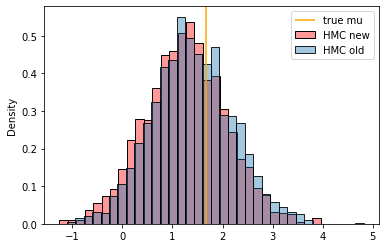

true x_1: tf.Tensor(1.6739499345270943, shape=(), dtype=float64) 
estimate: tf.Tensor(1.2629944052158395, shape=(), dtype=float64)


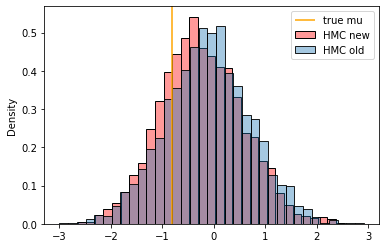

true x_2: tf.Tensor(-0.8109232714986124, shape=(), dtype=float64) 
estimate: tf.Tensor(-0.24123580045972134, shape=(), dtype=float64)


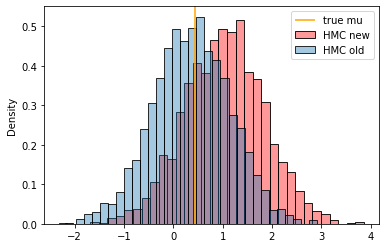

true x_3: tf.Tensor(0.4399671454377567, shape=(), dtype=float64) 
estimate: tf.Tensor(1.0304783976031795, shape=(), dtype=float64)


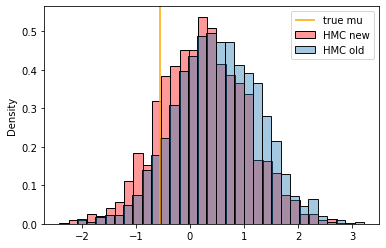

true x_4: tf.Tensor(-0.5540992987520248, shape=(), dtype=float64) 
estimate: tf.Tensor(0.2490939145706206, shape=(), dtype=float64)


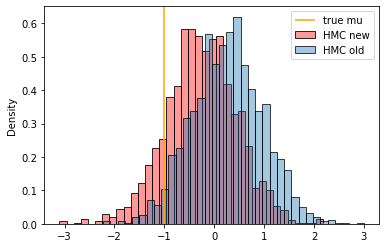

true x_5: tf.Tensor(-1.0, shape=(), dtype=float64) 
estimate: tf.Tensor(-0.2617529833942293, shape=(), dtype=float64)


In [20]:
# visualize old and new targets
for i in range(5):
    plot_hist(i, smc_res_new, smc_res, label1="HMC new", label2="HMC old")

## Improtance Sampling

In [27]:
def log_base_augment(x, log_target, h_dist):
    log_p_target = log_target(x[:, :5])
    log_p_h = h_dist.log_prob(x[:, 5]).reshape((-1, 1))
    return log_p_target + log_p_h

def log_target_new_augment(x, log_target_new, h_tilde_dist):
    x_tilde = tf.Variable(tf.identity(x))
    x_tilde[:, 2].assign(x[:, 5])
    x_tilde[:, 5].assign(x[:, 2])
    
    log_p_target_new = log_target_new(x_tilde[:, :5])
    log_p_htilde = h_tilde_dist.log_prob(x[:, 5]).reshape((-1, 1))
    return log_p_target_new + log_p_htilde

In [28]:
def IS_augmented_experiment(
    h_dist, 
    h_tilde_dist, 
    log_target_old,
    log_target_new,
    init_samples, 
    true_samples=None, 
    plot=True, 
    ind=0
):
    """
        log_target_old: log_prob function for old target
        log_target_new: log_prob function for new target
        init_samples: unaugmented base samples
    """
#     h_samples = h_dist.sample((N, 1))
    h_samples = h_dist.sample((1,)).T
    base_samples = tf.concat([init_samples, h_samples], axis=1)

    log_w = (
        log_target_new_augment(base_samples, log_target_new, h_tilde_dist) 
        - log_base_augment(base_samples, log_target_old, h_dist)
    )
    
    samples_plot = resample(log_w, base_samples)

    # compute ESS
    ess = effective_sample_size(log_w)
    
    # plot
    if plot:
        plot_hist(ind, samples_plot, smc_res_new, label1="IS augment", label2="HMC new")

    if true_samples is not None:
        energy_dist = energy_distance(
            samples_plot.reshape((-1,)), 
            true_samples.reshape((-1,))
        )
        return ess, energy_dist
    else:
        return ess
    

### Change sd

In [23]:
sd_list = [0.1, 1, 2, 5, 10]
nrep = 100

ess_list = -1 * np.ones((nrep, len(sd_list)))
energy_list = -1 * np.ones_like(ess_list)

# for constructing h_tilde
x3_mean = tf.math.reduce_mean(smc_res[:, 2])
x3_var = tf.math.reduce_variance(smc_res[:, 2])

for j, sd in enumerate(sd_list):
    print(f"Running for sd = {sd}")
    
    h_dist = Proposal(sd=np.ones(N)*sd)
#     h_tilde_dist = Proposal(N=N)
    h_tilde_dist = tfd.Laplace(
        loc=tf.ones(N) * x3_mean,
        scale=tf.ones(N) * x3_var
    )
    
    for i in range(nrep):
        ess, energy_dist = IS_augmented_experiment(
            h_dist, h_tilde_dist, log_target, log_target_new, smc_res, smc_res_new, plot=False)
        ess_list[i, j] = ess
        energy_list[i, j] = energy_dist

Running for sd = 0.1
Running for sd = 1
Running for sd = 2
Running for sd = 5
Running for sd = 10


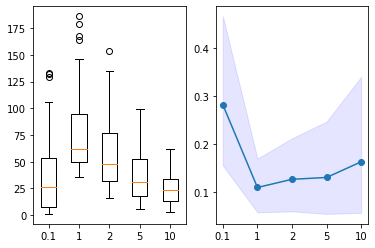

In [24]:
plt.subplot(1, 2, 1)
_ = plt.boxplot(ess_list)
_ = plt.xticks(range(1, 1 + len(sd_list)), sd_list)

plt.subplot(1, 2, 2)
_ = plt.plot(range(len(sd_list)), np.mean(energy_list, axis=0), marker="o")
_ = plt.fill_between(range(len(sd_list)),
                     np.percentile(energy_list, 2.5, axis=0), 
                     np.percentile(energy_list, 97.5, axis=0),
                     color='b', alpha=.1)
_ = plt.xticks(range(len(sd_list)), sd_list)


### Change mean

In [25]:
mean_list = [-2, -1, 0, 1, 2]
nrep = 100

ess_list = -1 * np.ones((nrep, len(sd_list)))
energy_list = -1 * np.ones_like(ess_list)

# for constructing h_tilde
x3_mean = tf.math.reduce_mean(smc_res[:, 2])
x3_var = tf.math.reduce_variance(smc_res[:, 2])

for j, mean in enumerate(mean_list):
    print(f"Running for mean = {mean}")

#     h_dist = Proposal(mean=np.ones(N) * mean)
#     h_tilde_dist = Proposal(N=N)

    h_dist = Proposal(mean=smc_res[:, 4] + mean)
    h_tilde_dist = tfd.Laplace(
        loc=tf.ones(N) * x3_mean,
        scale=tf.ones(N) * x3_var
    )
    
    for i in range(nrep):
        ess, energy_dist = IS_augmented_experiment(
            h_dist, h_tilde_dist, log_target, log_target_new, smc_res, smc_res_new, plot=False)
        ess_list[i, j] = ess
        energy_list[i, j] = energy_dist
    

Running for mean = -2
Running for mean = -1
Running for mean = 0
Running for mean = 1
Running for mean = 2


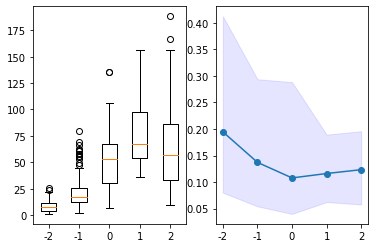

In [26]:
plt.subplot(1, 2, 1)
_ = plt.boxplot(ess_list)
_ = plt.xticks(range(1, 1 + len(mean_list)), mean_list)

plt.subplot(1, 2, 2)
_ = plt.plot(range(len(mean_list)), np.mean(energy_list, axis=0), marker="o")
_ = plt.fill_between(range(len(mean_list)),
                     np.percentile(energy_list, 2.5, axis=0), 
                     np.percentile(energy_list, 97.5, axis=0),
                     color='b', alpha=.1)
_ = plt.xticks(range(len(mean_list)), mean_list)


## 2. x = {x_1, x_2}, y = {x_3, x_4}, z = {x_5}
$p(x_5) = \mathcal{N}(0, 1) \to p(x_5) = \mathcal{N}(- 2, 1)$

In [29]:
def logprior_new(x):
    logp1 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 0:1])
    logp2 = tfd.Normal(loc=x[:, 3:4], scale=tau).log_prob(x[:, 1:2])   
    logp3 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 2:3])
    logp4 = tfd.Normal(loc=x[:, 4:5], scale=gamma).log_prob(x[:, 3:4])
    logprior5 = tfd.Normal(loc=mu0 - 2, scale=sigma0).log_prob(x[:, 4:5])
    return logp1 + logp2 + logp3 + logp4 + logprior5

def log_target_new(x):
    return logprior_new(x) + loglik(x)

In [30]:
N = 2000

# given samples from old target
samples_plot_init = tfd.Normal(loc=np.zeros(1), scale=np.ones(1)).sample((N, x_true.shape[1]))[:, :, 0]
samples_init = tf.Variable(samples_plot_init)

In [31]:
smc_res = tfp.experimental.mcmc.sample_sequential_monte_carlo(
    prior_log_prob_fn=logprior,
    likelihood_log_prob_fn=loglik,
    current_state=samples_init,
    seed=(12, 34))[1]

In [32]:
# get samples from new target (unavailable in practice)
samples_plot_init = tfd.Normal(loc=np.zeros(1), scale=np.ones(1)).sample((N, x_true.shape[1]))[:, :, 0]
samples_init = tf.Variable(samples_plot_init)

In [33]:
smc_res_new = tfp.experimental.mcmc.sample_sequential_monte_carlo(
    prior_log_prob_fn=logprior_new,
    likelihood_log_prob_fn=loglik,
    current_state=samples_init,
    seed=(12, 34))[1]

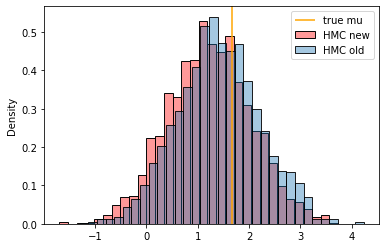

true x_1: tf.Tensor(1.6739499345270943, shape=(), dtype=float64) 
estimate: tf.Tensor(1.2214455237648774, shape=(), dtype=float64)


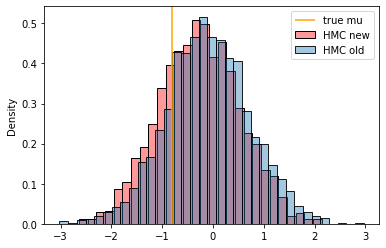

true x_2: tf.Tensor(-0.8109232714986124, shape=(), dtype=float64) 
estimate: tf.Tensor(-0.27392445175664737, shape=(), dtype=float64)


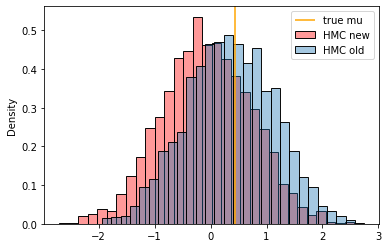

true x_3: tf.Tensor(0.4399671454377567, shape=(), dtype=float64) 
estimate: tf.Tensor(-0.07401917451992407, shape=(), dtype=float64)


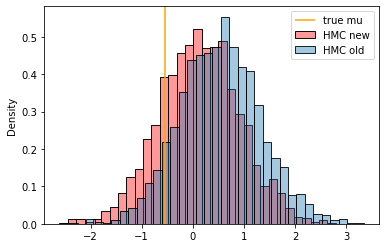

true x_4: tf.Tensor(-0.5540992987520248, shape=(), dtype=float64) 
estimate: tf.Tensor(0.12443193555957018, shape=(), dtype=float64)


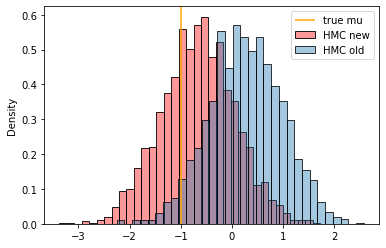

true x_5: tf.Tensor(-1.0, shape=(), dtype=float64) 
estimate: tf.Tensor(-0.6661611722876216, shape=(), dtype=float64)


In [34]:
# visualize old and new targets
for i in range(5):
    plot_hist(i, smc_res_new, smc_res, label1="HMC new", label2="HMC old")

## Importance sampling

### change sd

In [42]:
sd_list = [0.1, 1, 2, 5, 10]
nrep = 100

ess_list = -1 * np.ones((nrep, len(sd_list)))
energy_list = -1 * np.ones_like(ess_list)

# for constructing h_tilde
x3_mean = tf.math.reduce_mean(smc_res[:, 2])
x3_var = tf.math.reduce_variance(smc_res[:, 2])

for j, sd in enumerate(sd_list):
    print(f"Running for sd = {sd}")
    
    h_dist = Proposal(sd=np.ones(N)*sd)
#     h_tilde_dist = Proposal(N=N)
    h_tilde_dist = tfd.Laplace(
        loc=tf.ones(N) * x3_mean,
        scale=tf.ones(N) * x3_var
    )
    
    for i in range(nrep):
        ess, energy_dist = IS_augmented_experiment(
            h_dist, h_tilde_dist, log_target, log_target_new, smc_res, smc_res_new, plot=False)
        ess_list[i, j] = ess
        energy_list[i, j] = energy_dist
    

Running for sd = 0.1
Running for sd = 1
Running for sd = 2
Running for sd = 5
Running for sd = 10


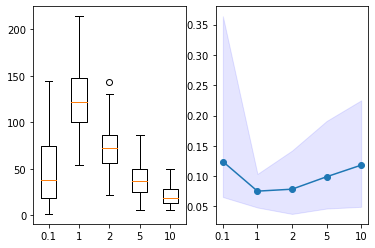

In [38]:
plt.subplot(1, 2, 1)
_ = plt.boxplot(ess_list)
_ = plt.xticks(range(1, 1 + len(sd_list)), sd_list)

plt.subplot(1, 2, 2)
_ = plt.plot(range(len(sd_list)), np.mean(energy_list, axis=0), marker="o")
_ = plt.fill_between(range(len(sd_list)),
                     np.percentile(energy_list, 2.5, axis=0), 
                     np.percentile(energy_list, 97.5, axis=0),
                     color='b', alpha=.1)
_ = plt.xticks(range(len(sd_list)), sd_list)


### change mean

In [43]:
mean_list = [-2, -1, 0, 1, 2]
nrep = 100

ess_list = -1 * np.ones((nrep, len(sd_list)))
energy_list = -1 * np.ones_like(ess_list)

# for constructing h_tilde
x3_mean = tf.math.reduce_mean(smc_res[:, 2])
x3_var = tf.math.reduce_variance(smc_res[:, 2])

for j, mean in enumerate(mean_list):
    print(f"Running for mean = {mean}")

#     h_dist = Proposal(mean=np.ones(1) * mean)
#     h_tilde_dist = Proposal()
    
    h_dist = Proposal(mean=np.ones(N) * (mu0 + mean))
    h_tilde_dist = tfd.Laplace(
        loc=tf.ones(N) * x3_mean,
        scale=tf.ones(N) * x3_var
    )
    
    for i in range(nrep):
        ess, energy_dist = IS_augmented_experiment(
            h_dist, h_tilde_dist, log_target, log_target_new, smc_res, smc_res_new, plot=False)
        ess_list[i, j] = ess
        energy_list[i, j] = energy_dist
    

Running for mean = -2
Running for mean = -1
Running for mean = 0
Running for mean = 1
Running for mean = 2


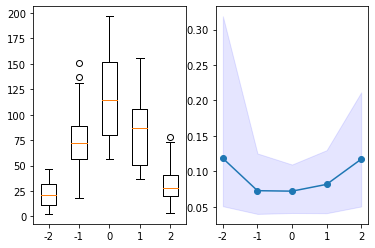

In [44]:
plt.subplot(1, 2, 1)
_ = plt.boxplot(ess_list)
_ = plt.xticks(range(1, 1 + len(mean_list)), mean_list)

plt.subplot(1, 2, 2)
_ = plt.plot(range(len(mean_list)), np.mean(energy_list, axis=0), marker="o")
_ = plt.fill_between(range(len(mean_list)),
                     np.percentile(energy_list, 2.5, axis=0), 
                     np.percentile(energy_list, 97.5, axis=0),
                     color='b', alpha=.1)
_ = plt.xticks(range(len(mean_list)), mean_list)
